# Additive Secret Sharing

Recall the "outsourced computation" protocol from the last chapter:

In [32]:
import pychor
client = pychor.Party('client')
server = pychor.Party('server')

with pychor.LocalBackend():
    xs = [1,2,3,4,5,6,7,8,9,10,11,12,13]@client
    ys = xs >> server
    result_server = (sum@server)(ys)
    print('Server result:', result_server)
    result_client = result_server >> client
    print('Client result:', result_client)

Server result: 91@server
Client result: 91@client


What if the client doesn't trust the server? Since the client sends all of the data to the server, an untrustworthy server could look at the data or share it with others---so our earlier protocol doesn't work very well if the client doesn't trust the server.

This chapter covers *additive secret sharing* \cite{todo}, a building block of MPC protocols that we'll use throughout the rest of this book. Additive secret sharing will allow the client to effectively encrypt the values being sent to the server - so the client will no longer need to trust the server not to look at the data. Importantly, additive secret sharing allows the server to *compute* on these encrypted values, so the server will still be able to perform the desired computation.

This combination of features sounds almost too good to be true, and it is - additive secret sharing comes with some important limitations that we'll cover at the end of the chapter.

## Building Additive Secret Shares

An additive secret sharing scheme consists of at least 2 functions:

- `share(x,n)` generates `n` secret shares of the secret value `x`
- `reconstruct(ss)` decrypts a secret value from a list `ss` of `n` secret shares

The two key requirements for an additive secret sharing scheme are:

1. The `n` secret shares should add up to `x` (this is the "additive" part)
2. *All* `n` secret shares are required to reconstruct `x` - it's impossible to learn anything about `x` from fewer than `n` shares (this is the "secret" part)

How do we meet both requirements at once? A simple way is to build the secret shares as *random numbers* (which clearly reveal nothing about the secret `x`), and then set the final share so that the shares add up to `x`. For example:

In [56]:
import random
import numpy as np

def share(x, n):
    # the first n-1 shares are random numbers
    shares = [np.random.randint(0, 10) for _ in range(n-1)]
    # the last share is chosen to make them add up to x
    shares.append(x - sum(shares))
    return shares

print('2 shares of the secret 5:', share(x=5, n=2))

2 shares of the secret 5: [3, 2]


This definition meets requirement #1! We can define the `reconstruct` function by simply adding up the shares, and we'll get `x`:

In [57]:
def reconstruct(ss):
    return sum(ss)

print('Reconstructed secret from the 2 shares:', reconstruct(share(x=5, n=2)))

Reconstructed secret from the 2 shares: 5


It also seems like it might meet requirement #2. The shares themselves are random numbers between 0 and 10, so they don't reveal anything about `x`. Right?

Not quite. Let's do an experiment to see if the shares are actually random. We'll run the `share` function 1000 times, generating secret shares of `x=5`, then count how many times each number between 0 and 10 occurs in each share position. Let's do the first share first:

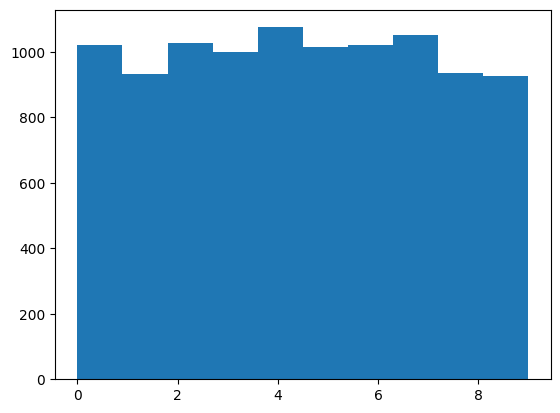

In [60]:
import matplotlib.pyplot as plt
results = [share(x=5, n=2) for _ in range(10000)]
plt.hist([r[0] for r in results], bins=10);

Sure enough, all results between 0 and 10 seem to be equally likely. The bars aren't identical because we've approximated the distribution of random shares by sampling 10000 times; if we increased the number of samples, the bars would get closer together.

This result is an example of *uniform randomness* - it's just like flipping a fair coin or rolling a fair 6-sided die. The graph would look the same no matter what `x` was - the first share doesn't reveal anything about `x`.

Let's see if the same thing is true for the second share:

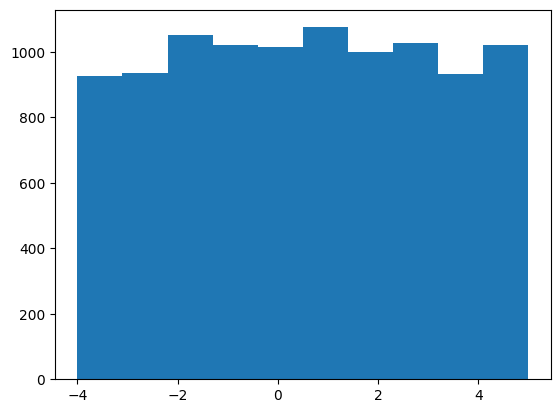

In [62]:
plt.hist([r[1] for r in results], bins=10);

This graph has a similar shape, but the maximum and minimum are different - there are no results smaller than -5, and there are lots of results bigger than 10. Unfortunately, this is a sign that the second share - by itself - can sometimes reveal something about `x`.

For example, if the second share's value is 15, then `x` *must have been* at least 5 - since the first share was between -10 and 10, any secret smaller than 5 would make it impossible for the second share to be 15.

This is a major security flaw, since neither share by itself is supposed to reveal anything about `x`. To fix this problem, we could use larger bounds than -10 and 10, which might make it harder to observe one of the problematic cases - but no matter how large we make the bounds, the same kind of leeakage is possible at the extreme values.

## Finite Fields and Modular Arithmetic

To solve this problem, most encryption systems use *modular arithmetic* (TODO LINK). To implement this approach, we'll pick an upper bound for our numbers (e.g. 10), and perform all arithmetic modulo this number. This special number is called the *modulus* and is conventionally denoted by the letters `p` or `q`. For example:

In [66]:
p = 10
print('2+3 mod p:', (2+3)%p)
print('2+7 mod p:', (2+7)%p)
print('5+7 mod p:', (5+7)%p)

2+3 mod p: 5
2+7 mod p: 9
5+7 mod p: 2


Modular arithmetic means that when the result would exceed `p`, it "wraps around" back to 0 - this is why `5+7 mod p` is 2.